# Imports

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(1)

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Functions

In [12]:

from collections import Counter

import torch

def check_class_imbalance(df):
  
  y = df.values[:,-1]
  counter = Counter(y)
  
  for k,v in counter.items():
    per = v/len(y) * 100
    print("Class=%s, Count=%d, Percentage=%.3f%%" % (k,v, per))
    
def sentiment_score(review, tokenizer, model):
  tokens = tokenizer.encode(review, return_tensors='pt')
  result = model(tokens)
  return int(torch.argmax(result.logits)) +1


In [3]:
filename = "/Users/test/Downloads/Tweets.csv"

# EDA Analysis

In [15]:
df_ = pd.read_csv(filename, nrows = 1000)
df_

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,569970938525016065,negative,1.0000,Late Flight,0.7065,United,NaN,tbird12lv,NaN,0,@united by the time I finally get to Dallas I ...,NaN,2015-02-23 13:23:55 -0800,Colorado,Mountain Time (US & Canada)
996,569970599377788928,negative,1.0000,Late Flight,1.0000,United,NaN,cristobalwong,NaN,0,@united I'm trying to get to my final destinat...,NaN,2015-02-23 13:22:35 -0800,San Francisco Bay Area,NaN
997,569970225443172353,negative,1.0000,Customer Service Issue,0.6667,United,NaN,itsmetsforme,NaN,0,@united that guy really has no customer servic...,NaN,2015-02-23 13:21:05 -0800,mets hell,NaN
998,569969999961391105,positive,0.6915,NaN,NaN,United,NaN,swampynomo,NaN,0,@united he has no priority and Iove it,NaN,2015-02-23 13:20:12 -0800,NJ/NYC,Eastern Time (US & Canada)


In [16]:
df = df_[["text",'airline_sentiment']].copy()
df

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
...,...,...
995,@united by the time I finally get to Dallas I ...,negative
996,@united I'm trying to get to my final destinat...,negative
997,@united that guy really has no customer servic...,negative
998,@united he has no priority and Iove it,positive


In [18]:
check_class_imbalance(df)

Class=neutral, Count=272, Percentage=27.200%
Class=positive, Count=214, Percentage=21.400%
Class=negative, Count=514, Percentage=51.400%


In [19]:
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

In [20]:
text_mapping = {"positive":1, 'neutral':0, "negative":2}

df['target'] = df['airline_sentiment'].map(text_mapping)

In [21]:
df["berta_model"] = df["text"].apply(lambda review: sentiment_score(review, tokenizer, model))

In [23]:
df.drop('airline_sentiment', axis=1, inplace=True)

In [24]:
df

,text,target,berta_model
0,@VirginAmerica What @dhepburn said.,0,5
1,@VirginAmerica plus you've added commercials t...,1,5
2,@VirginAmerica I didn't today... Must mean I n...,0,1
3,@VirginAmerica it's really aggressive to blast...,2,4
4,@VirginAmerica and it's a really big bad thing...,2,1
...,...,...,...
995,@united by the time I finally get to Dallas I ...,2,2
996,@united I'm trying to get to my final destinat...,2,1
997,@united that guy really has no customer servic...,2,1
998,@united he has no priority and Iove it,1,1


<Axes: xlabel='berta_model'>

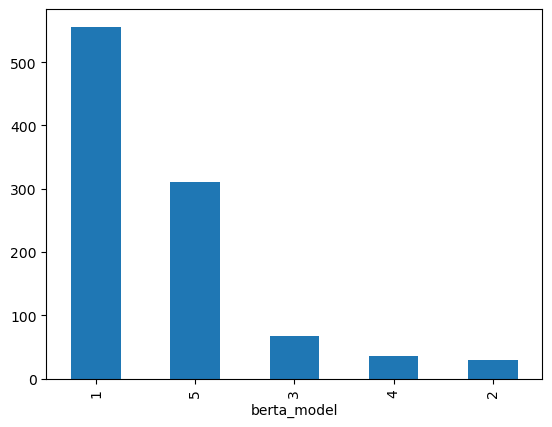

In [26]:
df['berta_model'].value_counts().plot.bar()

<Axes: xlabel='target'>

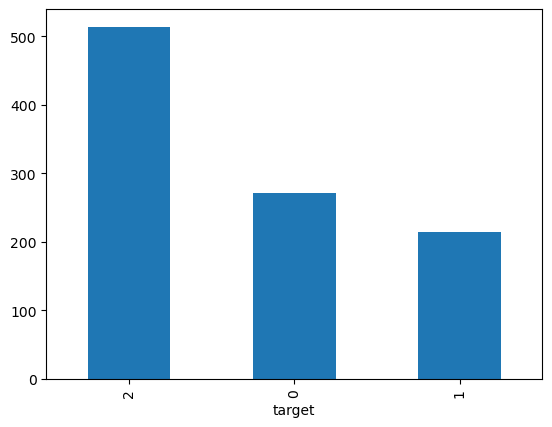

In [27]:
df['target'].value_counts().plot.bar()

In [33]:
neutral_reviews = df[(df["berta_model"] ==2) | (df['berta_model'] ==3) ]["text"]

In [35]:
for review in neutral_reviews:
  print(review)

@VirginAmerica Are the hours of operation for the Club at SFO that are posted online current?
@VirginAmerica awaiting my return phone call, just would prefer to use your online self-service option :(
@VirginAmerica Hey, first time flyer next week - excited! But I'm having a hard time getting my flights added to my Elevate account. Help?
@VirginAmerica hi I just booked a flight but need to add baggage, how can I do this?
@VirginAmerica your airline is awesome but your lax loft needs to step up its game. $40 for dirty tables and floors? http://t.co/hy0VrfhjHt
@VirginAmerica I like the TV and interesting video . Just disappointed in Cancelled Flightled flight when other flights went out to jfk on Saturday .
@VirginAmerica Is it me, or is your website down?  BTW, your new website isn't a great user experience.  Time for another redesign.
@VirginAmerica I like the customer service but a 40 min delay just for connecting passengers seems too long. VA370
@VirginAmerica I need to register a ser

In [36]:
four_star_reviews = df[df["berta_model"] ==4 ]["text"]

In [39]:
for idx, review in enumerate(four_star_reviews):
  print(idx, review)

0 @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
1 Nice RT @VirginAmerica: Vibe with the moodlight from takeoff to touchdown. #MoodlitMonday #ScienceBehindTheExperience http://t.co/Y7O0uNxTQP
2 @VirginAmerica @ladygaga @carrieunderwood Julie Andrews all the way though @ladygaga was very impressive! NO to @Carrieunderwood
3 @VirginAmerica @ladygaga @carrieunderwood all are great , but I have to go with #CarrieUnderwood 😍👌
4 @VirginAmerica everything was fine until you lost my bag
5 @VirginAmerica your beautiful front-end design is down right now; but it was cool to still book my ticket b/c all your back-end was secure.
6 @VirginAmerica Do you provide complimentary upgrades to first class, if there are available seats?
7 @VirginAmerica Adds Pillows Instead of Lie-Flat Seats in First Class Arms Race http://t.co/rGYwJBbhm4
8 @VirginAmerica loved it. Can't wait for Monday's return flight... Mostly just to watch 

In [44]:
four_star_reviews

3      @VirginAmerica it's really aggressive to blast...
35     Nice RT @VirginAmerica: Vibe with the moodligh...
51     @VirginAmerica @ladygaga @carrieunderwood Juli...
62     @VirginAmerica @ladygaga @carrieunderwood all ...
69     @VirginAmerica everything was fine until you l...
118    @VirginAmerica your beautiful front-end design...
125    @VirginAmerica Do you provide complimentary up...
268    @VirginAmerica Adds Pillows Instead of Lie-Fla...
303    @VirginAmerica loved it. Can't wait for Monday...
359    @VirginAmerica love you guys, but pls get some...
373    @VirginAmerica Adds Pillows Instead of Lie-Fla...
397    @VirginAmerica good to be home #texas #moodlig...
432    @VirginAmerica Nice to see you expanding in Te...
464    Nice RT @VirginAmerica: The man of steel might...
479    @VirginAmerica started my flight with a scoldi...
483    @VirginAmerica should use this in their next a...
502    @VirginAmerica Flying LAX to SFO and after loo...
513    @united Gate agent hooke

# Sarcasm is not detected well in the model

In [45]:
four_star_reviews[907]

'@united also, the mere fact that I have to go online to issue a statement vice calling and talking to some directly is one good example.'

In [46]:
four_star_reviews[69]

'@VirginAmerica everything was fine until you lost my bag'

In [47]:
four_star_reviews[909]

'@united  i have a weekend of dealing with your company that would say otherwise.'

In [48]:
from scipy.special import softmax

def polarity_scores_roberta(example):
  encoded_text = tokenizer(example, return_tensors='pt')
  output = model(**encoded_text)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  scores_dict = {
  "roberta_neg":scores[0],
  "roberta_neu":scores[1],
  "roberta_pos":scores[2]
  }
  
  return scores_dict